In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../secondMMRintData/tryMaxMMRwidInitial.csv')

In [3]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [4]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.79 s, sys: 42.1 ms, total: 5.84 s
Wall time: 5.84 s


In [5]:
dataset['EMavg'] = (dataset['EMcrossfar']+dataset['EMcrossnear']+dataset['EMcrossouter'])/3

In [6]:
dataset['Widavg']= (dataset['MMRstrengthWnear']+dataset['MMRstrengthWfar']+dataset['MMRstrengthWouter'])/3

In [7]:
dataset

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,0,0.221502,0.098431,9.878834e-03,0.013642,0.007103,0.300893,0.093415,0.001595,0.003112,...,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.009765
1,1,0.190647,0.009185,1.703367e-03,0.019474,0.015939,0.403777,0.249341,0.003783,0.008003,...,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.009333
2,2,0.125660,0.426660,1.310313e-01,0.033117,0.022168,0.720557,0.000531,0.000266,0.000287,...,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.013826
3,3,0.216684,0.002876,1.857040e-07,0.004557,0.001577,0.235460,0.027521,0.013379,0.001208,...,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.002047
4,4,0.024455,0.423830,1.145611e-01,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714
138539,138539,0.251338,0.749336,1.701463e-03,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352
138540,138540,0.131799,0.324267,2.940005e-02,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406
138541,138541,0.209454,1.205802,5.207774e-02,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591


In [8]:


twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']

MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter', 'EMcrossnear','EMcrossfar','EMcrossouter','eccMag','eccDir','pomegastd',
           ]+twoBRwidth

TestFirst = ['threeBRfillfac', 'threeBRfillstd','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter']

testfew = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter', 'threeBRfillfac','EMcrossnear','EMcrossfar','EMcrossouter']

testavg = ['EMavg','Widavg','threeBRfillfac']

In [9]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [10]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,0,0.221502,0.098431,9.878834e-03,0.013642,0.007103,0.300893,0.093415,0.001595,0.003112,...,0.053981,0.007530,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.009765
1,1,0.190647,0.009185,1.703367e-03,0.019474,0.015939,0.403777,0.249341,0.003783,0.008003,...,0.017682,0.082772,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.009333
2,2,0.125660,0.426660,1.310313e-01,0.033117,0.022168,0.720557,0.000531,0.000266,0.000287,...,0.042240,0.054516,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.013826
3,3,0.216684,0.002876,1.857040e-07,0.004557,0.001577,0.235460,0.027521,0.013379,0.001208,...,0.013245,0.057501,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.002047
4,4,0.024455,0.423830,1.145611e-01,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.006777,0.011759,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.098020,0.132139,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714
138539,138539,0.251338,0.749336,1.701463e-03,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.017757,0.043224,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352
138540,138540,0.131799,0.324267,2.940005e-02,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.064086,0.047189,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406
138541,138541,0.209454,1.205802,5.207774e-02,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.091233,0.217038,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591


In [11]:
scrambled = filtData.sample(frac=1)

In [12]:
scrambled = scrambled.reset_index()

In [13]:
scrambled

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,35143,35143,0.251383,0.495761,0.000608,0.006924,0.006990,0.372909,0.030107,0.012189,...,0.020388,0.169868,0.038522,True,False,5.115604e+06,2.294592e+06,0,0.447443,0.004769
1,98802,98802,0.215120,0.273773,0.006037,0.014407,0.005875,0.596013,0.433570,0.000000,...,0.046765,0.223645,0.081206,True,False,1.417489e+08,5.803351e+05,0,0.583494,0.015697
2,38012,38012,0.130293,1.184726,0.047975,0.026650,0.023073,0.192884,0.009942,0.008150,...,0.003723,0.056499,0.055232,True,False,1.797758e+04,3.201024e+04,0,0.223829,0.019076
3,5565,5565,0.113772,0.039666,0.016960,0.007185,0.007391,0.482647,0.000149,0.000141,...,0.004415,0.017461,0.001110,True,False,8.005707e+07,2.266247e+08,0,0.415917,0.004974
4,39907,39907,0.087150,0.126158,0.017889,0.000525,0.002342,0.319593,0.029403,0.000011,...,0.006649,0.005136,0.000990,True,True,1.000000e+09,1.000000e+09,0,0.280446,0.001257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,89050,89050,0.066111,0.222766,0.018889,0.005238,0.005291,0.190181,0.013560,0.012035,...,0.025441,0.024116,0.016184,True,True,1.000000e+09,1.000000e+09,0,0.175052,0.003475
138539,59038,59038,0.210452,1.759091,0.023275,0.023793,0.020175,0.309212,1.968662,0.007784,...,0.045970,0.168573,0.061984,True,True,1.000000e+09,1.000000e+09,0,0.368134,0.024713
138540,134727,134727,0.054979,0.349016,0.013409,0.002810,0.002830,0.074184,0.015847,0.003362,...,0.010266,0.008661,0.010001,True,False,5.598546e+04,5.028230e+04,0,0.087468,0.002123
138541,46031,46031,0.255065,0.100708,0.011646,0.010289,0.007703,0.333641,0.094652,0.008708,...,0.002577,0.021912,0.007685,True,False,5.958639e+04,4.754143e+04,0,0.420837,0.007404


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [14]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [15]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [16]:
realTest = test.loc[test['prelimStable']==True]

In [17]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [18]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
train

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,...,EPfar,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg
0,35143,35143,0.251383,0.495761,0.000608,0.006924,0.006990,0.372909,0.030107,0.012189,...,0.020388,0.169868,0.038522,True,False,5.115604e+06,2.294592e+06,0,0.447443,0.004769
1,98802,98802,0.215120,0.273773,0.006037,0.014407,0.005875,0.596013,0.433570,0.000000,...,0.046765,0.223645,0.081206,True,False,1.417489e+08,5.803351e+05,0,0.583494,0.015697
2,38012,38012,0.130293,1.184726,0.047975,0.026650,0.023073,0.192884,0.009942,0.008150,...,0.003723,0.056499,0.055232,True,False,1.797758e+04,3.201024e+04,0,0.223829,0.019076
3,5565,5565,0.113772,0.039666,0.016960,0.007185,0.007391,0.482647,0.000149,0.000141,...,0.004415,0.017461,0.001110,True,False,8.005707e+07,2.266247e+08,0,0.415917,0.004974
4,39907,39907,0.087150,0.126158,0.017889,0.000525,0.002342,0.319593,0.029403,0.000011,...,0.006649,0.005136,0.000990,True,True,1.000000e+09,1.000000e+09,0,0.280446,0.001257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110829,42929,42929,0.050322,0.185039,0.017227,0.003135,0.003119,0.309340,0.224460,0.000031,...,0.020470,0.017549,0.011894,True,False,8.623067e+04,5.895672e+06,0,0.244963,0.001878
110830,29221,29221,0.129390,1.103942,0.006407,0.003539,0.003441,0.301897,0.033284,0.000254,...,0.002987,0.014279,0.009313,True,True,9.990000e+08,9.990000e+08,0,0.300546,0.001986
110831,52196,52196,0.118410,0.074257,0.028030,0.001971,0.006562,0.134551,0.010682,0.009284,...,0.005297,0.047126,0.026268,True,False,2.881042e+05,4.796485e+04,0,0.173951,0.002121
110832,55924,55924,0.065982,0.458552,0.028481,0.005432,0.005487,0.171306,0.028199,0.004461,...,0.005160,0.019907,0.001722,True,False,1.109812e+04,1.261175e+04,0,0.161960,0.005006


In [26]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [27]:
testModel.fit(train[testavg], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
resPred = testModel.predict_proba(tT[testavg])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[MMRDATA]), tT["Stable"]))

0.9501076186515158
0.861718910762055


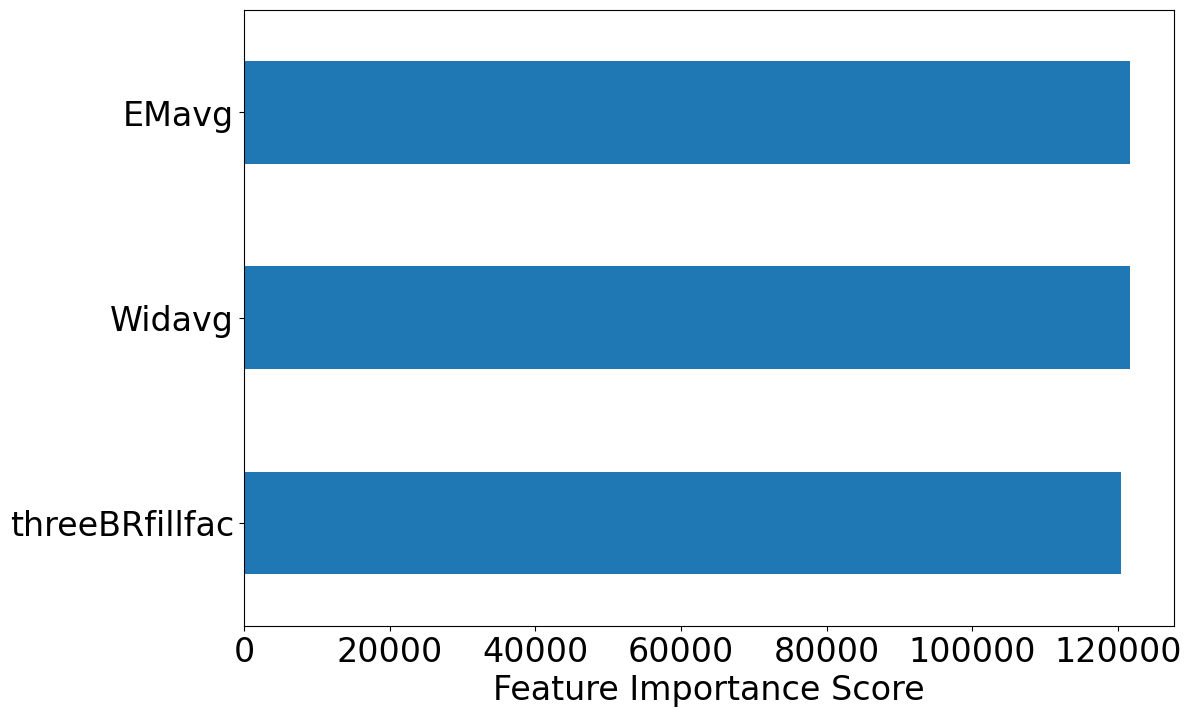

In [43]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 20.0)

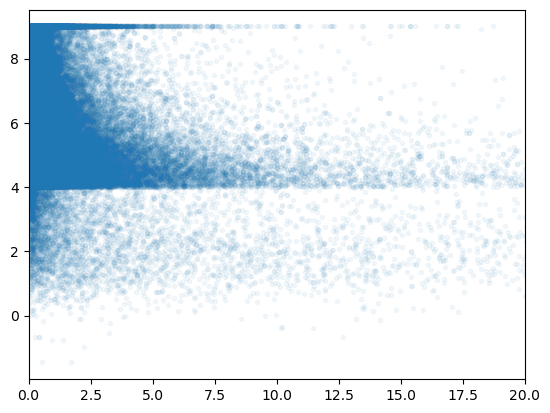

In [28]:
plt.plot(train['threeBRfillfac'],np.log10(train['instability_time']), '.', alpha = .05)
ax = plt.gca()
ax.set_xlim([0,20])


In [29]:
which = (filtData['MMRstrengthnear']+filtData['MMRstrengthfar']+filtData['MMRstrengthouter'])

In [30]:
filtData['avarage']=which

In [31]:
filtData['Wavarage']=(filtData['MMRstrengthWnear']+filtData['MMRstrengthWfar']+filtData['MMRstrengthWouter'])/3

In [32]:
np.median(filtData['avarage'])

0.42239726010197315

In [33]:
#filtData = filtData.drop(['avarage'], axis=1)

In [34]:
filtData

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,avarage,Wavarage
0,0,0.221502,0.098431,9.878834e-03,0.013642,0.007103,0.300893,0.093415,0.001595,0.003112,...,0.004649,True,False,1.235665e+07,8.315223e+07,0,0.370479,0.009765,0.632254,0.009765
1,1,0.190647,0.009185,1.703367e-03,0.019474,0.015939,0.403777,0.249341,0.003783,0.008003,...,0.071393,True,False,1.348749e+05,2.133072e+05,0,0.421943,0.009333,0.258671,0.009333
2,2,0.125660,0.426660,1.310313e-01,0.033117,0.022168,0.720557,0.000531,0.000266,0.000287,...,0.051803,True,False,1.276428e+04,9.321863e+03,0,0.594326,0.013826,0.428024,0.013826
3,3,0.216684,0.002876,1.857040e-07,0.004557,0.001577,0.235460,0.027521,0.013379,0.001208,...,0.040897,True,True,1.000000e+09,1.000000e+09,0,0.318436,0.002047,0.030655,0.002047
4,4,0.024455,0.423830,1.145611e-01,0.002436,0.000582,0.034058,0.079484,0.053510,0.003246,...,0.007401,True,False,8.791890e+01,8.791890e+01,0,0.039287,0.002854,0.611820,0.002854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.447117,2.475049e-02,0.016075,0.016330,0.664222,0.001175,0.000000,0.004940,...,0.073446,True,False,6.990387e+05,8.267916e+05,0,0.515834,0.007714,0.457666,0.007714
138539,138539,0.251338,0.749336,1.701463e-03,0.003767,0.002099,0.272822,0.017013,0.004713,0.007723,...,0.003523,True,False,3.075749e+08,6.576003e+08,0,0.372297,0.005352,0.925451,0.005352
138540,138540,0.131799,0.324267,2.940005e-02,0.017772,0.017278,0.366664,0.059764,0.006983,0.001049,...,0.045870,True,False,1.193822e+07,3.363291e+07,0,0.348418,0.014406,0.456770,0.014406
138541,138541,0.209454,1.205802,5.207774e-02,0.033014,0.057969,0.395073,0.029166,0.002591,0.020718,...,0.183490,True,False,2.064407e+08,4.316851e+07,0,0.430601,0.028591,1.237314,0.028591


In [44]:
filtData['spockRes'] = testModel.predict(filtData[testavg])

In [45]:
filtData['spockRight'] = filtData['spockRes']==filtData['Stable']

In [63]:
filtData['emdwid']= filtData['EMavg']/filtData['Widavg']

In [64]:
checkF = filtData.drop(filtData[filtData['spockRight']==True].index)
checkT = filtData.drop(filtData[filtData['spockRight']==False].index)

In [99]:
checkF.describe()-checkT.describe()

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPouter,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,avarage,Wavarage,spockRes,emdwid
count,-121187.000000,-121187.000000,-1.211870e+05,-121187.000000,-1.211870e+05,-1.211870e+05,-121187.000000,-1.211870e+05,-121187.000000,-1.211870e+05,...,-121187.000000,-1.211870e+05,-1.211870e+05,-121187.0,-121187.000000,-121187.000000,-121187.000000,-121187.000000,-121187.000000,-1.211870e+05
mean,1039.420831,0.034717,1.535676e-01,-0.020699,-1.774217e-03,-2.907145e-03,0.110936,-7.619669e-01,-0.003919,-5.178774e-04,...,0.000952,7.630078e+07,8.428580e+07,0.0,0.106368,-0.001019,0.653562,-0.001019,0.434731,-3.185368e+02
std,80.962426,0.000105,-8.207555e+01,-0.709502,-9.473021e-02,-9.570709e-02,-0.004178,-1.198412e+02,-0.014096,-1.999609e-03,...,-0.005485,1.380514e+07,1.762249e+07,0.0,-0.014024,-0.029471,-47.866964,-0.029471,0.022457,-4.943385e+04
min,2.000000,0.009574,3.146346e-07,0.000000,4.555864e-11,1.247013e-10,0.050943,2.421775e-10,0.000000,6.369585e-10,...,0.000001,7.967434e-01,0.000000e+00,0.0,0.055429,0.000034,0.001185,0.000034,0.000000,1.240339e+01
25%,339.500000,0.030975,3.060332e-03,-0.002330,9.377779e-05,1.232967e-04,0.116675,-3.562641e-03,-0.000161,-1.791599e-04,...,0.000549,6.047040e+05,5.838068e+05,0.0,0.116953,0.000107,0.001144,0.000107,0.000000,1.979880e+01
50%,1371.500000,0.033657,1.351426e-02,-0.004274,2.160867e-04,9.669358e-05,0.127484,-9.863020e-03,-0.001217,-1.192420e-04,...,0.002039,3.018928e+07,3.166939e+07,0.0,0.127890,0.000180,-0.012503,0.000180,1.000000,2.854015e+01
75%,2181.750000,0.064283,4.849810e-02,-0.005821,-1.612921e-04,-3.563523e-04,0.114167,-2.245726e-02,-0.004356,1.149869e-04,...,0.004131,0.000000e+00,0.000000e+00,0.0,0.119304,-0.000490,0.018453,-0.000490,0.000000,4.516145e+01
max,-15.000000,-0.109117,-5.169420e+04,-237.478805,-3.484562e+01,-2.044221e+01,-0.067025,-3.968365e+04,-3.175100,-3.220986e-01,...,-0.584886,3.961827e-01,-1.299678e+03,0.0,-0.131432,-11.603323,-46447.761530,-11.603323,0.000000,-1.620778e+07


In [58]:
checkT.describe()

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EMouter,EPouter,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,avarage,Wavarage,spockRes
count,129865.000000,129865.000000,1.298650e+05,129865.000000,1.298650e+05,1.298650e+05,129865.000000,1.298650e+05,129865.000000,1.298650e+05,...,129865.000000,1.298650e+05,1.298650e+05,1.298650e+05,129865.0,129865.000000,1.298650e+05,1.298650e+05,1.298650e+05,129865.000000
mean,69205.893181,0.148006,3.166507e+00,0.040633,9.390058e-03,1.059018e-02,0.355718,1.648488e+00,0.006576,7.059078e-03,...,0.065652,3.620362e-02,2.815354e+08,2.872612e+08,0.0,0.357123,7.241736e-03,5.750022e+00,7.241736e-03,0.259439
std,39988.339193,0.112599,1.909836e+02,0.743214,1.029694e-01,1.055942e-01,0.201556,1.310826e+02,0.019362,1.026093e-02,...,0.078121,5.296472e-02,4.359062e+08,4.401991e+08,0.0,0.207730,3.541599e-02,2.434898e+02,3.541599e-02,0.438328
min,0.000000,0.004612,1.849842e-10,0.000000,4.213181e-14,2.116006e-13,0.006545,2.656761e-12,0.000000,1.979369e-14,...,0.000002,9.222669e-07,3.464102e-02,0.000000e+00,0.0,0.008290,6.346495e-08,1.876380e-08,6.346495e-08,0.000000
25%,34607.000000,0.069412,5.622002e-02,0.006516,1.711162e-03,1.779838e-03,0.195417,7.201677e-03,0.000198,1.287074e-03,...,0.016120,4.958783e-03,5.883475e+04,5.288689e+04,0.0,0.200299,2.003265e-03,1.504845e-01,2.003265e-03,0.000000
50%,69176.000000,0.117811,1.874896e-01,0.016209,4.472789e-03,4.486955e-03,0.311935,2.742681e-02,0.001863,3.538230e-03,...,0.039284,1.730931e-02,1.192397e+06,1.203278e+06,0.0,0.312097,4.317398e-03,4.230441e-01,4.317398e-03,0.000000
75%,103784.000000,0.183550,6.684855e-01,0.032001,1.089323e-02,1.040178e-02,0.481279,9.690949e-02,0.007187,8.898316e-03,...,0.085028,4.554873e-02,1.000000e+09,1.000000e+09,0.0,0.471144,8.753258e-03,1.311559e+00,8.753258e-03,1.000000
max,138542.000000,0.982453,6.151829e+04,238.997268,3.495459e+01,2.064828e+01,1.194679,4.028690e+04,3.251414,4.899060e-01,...,1.018244,9.965833e-01,1.000050e+09,1.000050e+09,0.0,1.729078,1.169559e+01,6.151832e+04,1.169559e+01,1.000000


In [104]:
fillfactest = filtData.drop(filtData[filtData['threeBRfillfac']>2].index)

In [105]:
fillfactest.describe()

,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,twoMMRstrengthWnear,EMcrossfar,MMRstrengthfar,twoMMRstrengthfar,MMRstrengthWfar,...,EPouter,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,avarage,Wavarage,spockRes,emdwid
count,114446.000000,114446.000000,1.144460e+05,114446.000000,1.144460e+05,1.144460e+05,114446.000000,1.144460e+05,114446.000000,1.144460e+05,...,1.144460e+05,1.144460e+05,1.144460e+05,114446.0,114446.000000,1.144460e+05,1.144460e+05,1.144460e+05,114446.000000,1.144460e+05
mean,69952.037747,0.168935,3.492187e+00,0.025929,9.003970e-03,9.376806e-03,0.384276,1.862311e+00,0.005263,7.414575e-03,...,3.950010e-02,3.327984e+08,3.397500e+08,0.0,0.394120,7.325395e-03,6.403840e+00,7.325395e-03,0.335861,5.396410e+02
std,39770.600951,0.114753,2.051538e+02,0.190042,2.638942e-02,3.349430e-02,0.199002,1.396340e+02,0.009946,1.062263e-02,...,5.483569e-02,4.551518e+08,4.594044e+08,0.0,0.208216,1.217032e-02,2.610851e+02,1.217032e-02,0.472293,5.300433e+04
min,0.000000,0.014950,1.849842e-10,0.000000,4.213181e-14,2.116006e-13,0.047060,2.656761e-12,0.000000,1.979369e-14,...,9.222669e-07,3.464102e-02,0.000000e+00,0.0,0.060371,6.346495e-08,1.876380e-08,6.346495e-08,0.000000,3.497938e-01
25%,35782.250000,0.088735,5.401525e-02,0.004999,1.817756e-03,1.843842e-03,0.224950,6.553337e-03,0.000141,1.310171e-03,...,5.937251e-03,1.363567e+05,1.271817e+05,0.0,0.235982,2.137589e-03,1.526444e-01,2.137589e-03,0.000000,4.164148e+01
50%,70161.500000,0.138729,1.886316e-01,0.013686,4.778899e-03,4.673283e-03,0.347438,2.666126e-02,0.001461,3.717188e-03,...,1.996931e-02,4.701947e+06,4.785182e+06,0.0,0.352918,4.590106e-03,4.436800e-01,4.590106e-03,0.000000,7.068401e+01
75%,104368.750000,0.211982,7.013462e-01,0.028398,1.140445e-02,1.063919e-02,0.514797,9.929338e-02,0.005902,9.487778e-03,...,5.099794e-02,1.000000e+09,1.000000e+09,0.0,0.513890,9.188252e-03,1.426693e+00,9.188252e-03,1.000000,1.325029e+02
max,138542.000000,0.982453,6.151829e+04,30.047939,3.253013e+00,3.415375e+00,1.194679,4.028690e+04,0.325131,4.899060e-01,...,9.965833e-01,1.000050e+09,1.000050e+09,0.0,1.729078,1.107327e+00,6.151832e+04,1.107327e+00,1.000000,1.621810e+07


In [128]:
plot = filtData.drop(filtData[filtData['threeBRfillfac'] >20].index)
#plot = plot.drop(plot[plot['emdwid'] >900].index)
#plot = plot.drop(plot[plot['threeBRfillfac'] <1].index)
#plot = plot.drop(plot[plot['avarage'] >50].index)


/tmp/ipykernel_45147/53794074.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter((plot['threeBRfillfac']),np.log10(plot['instability_time']), s=1, c=((plot['MMRstrengthnear'])), cmap=plt.cm.get_cmap("copper_r",5),alpha=1)


(4.0, 9.0)

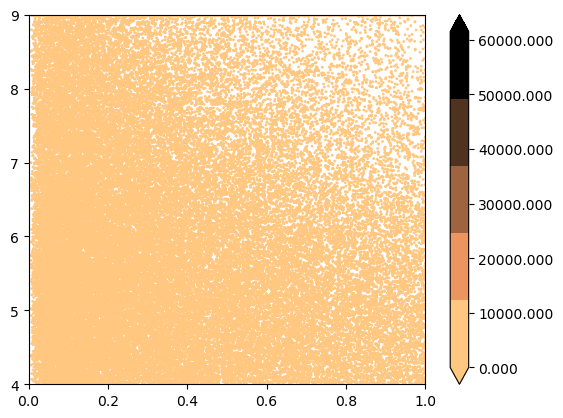

In [130]:
ax = plt.axes()
plt.scatter((plot['threeBRfillfac']),np.log10(plot['instability_time']), s=1, c=((plot['MMRstrengthnear'])), cmap=plt.cm.get_cmap("copper_r",5),alpha=1)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,1])
ax.set_ylim([4,9])

In [ ]:
ax = plt.axes()
plt.scatter((plot['threeBRfillfac']),np.log10(plot['instability_time']), s=1, c=(plot['spockRight']), marker='.',cmap=plt.cm.get_cmap("copper",5),alpha=1)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,20])
ax.set_ylim([4,9.5])

In [37]:
tester = filtData.drop(filtData[filtData['threeBRfillfac']**.5 >.5].index)
tester = tester.drop(tester[tester['threeBRfillfac']**.5 <.4].index)

In [239]:
tester[MMRDATA].describe()

,threeBRfillfac,MMRstrengthnear,MMRstrengthfar,MMRstrengthouter,twoMMRstrengthnear,twoMMRstrengthfar,twoMMRstrengthouter,EMcrossnear,EMcrossfar,EMcrossouter,...,pomegastd,Pratnear,Pratfar,Pratouter,MMRstrengthWnear,MMRstrengthWfar,MMRstrengthWouter,twoMMRstrengthWnear,twoMMRstrengthWfar,twoMMRstrengthWouter
count,13927.000000,1.392700e+04,1.392700e+04,1.392700e+04,13927.000000,13927.000000,13927.000000,13927.000000,13927.000000,13927.000000,...,13927.000000,13927.000000,13927.000000,13927.000000,13927.000000,1.392700e+04,1.392700e+04,13927.000000,13927.000000,13927.000000
mean,0.202610,4.233078e+00,1.241559e+00,9.963643e-01,0.021156,0.004420,0.000745,0.181675,0.406822,0.670079,...,1.843693,0.787429,0.619091,0.492020,0.007749,6.533195e-03,4.115639e-03,0.007149,0.002855,0.001008
std,0.026005,1.547172e+02,2.294072e+01,2.305143e+01,0.140790,0.008372,0.001852,0.096616,0.191927,0.314896,...,0.978380,0.087719,0.117887,0.125914,0.025242,8.984475e-03,6.598023e-03,0.025501,0.006315,0.003313
min,0.160000,6.213388e-07,2.448343e-10,2.140631e-12,0.000000,0.000000,0.000000,0.034824,0.079328,0.151738,...,0.006911,0.459053,0.321607,0.153010,0.000001,8.072375e-10,9.711670e-12,0.000000,0.000000,0.000000
25%,0.179714,5.598301e-02,6.365362e-03,8.550696e-04,0.004081,0.000113,0.000000,0.109276,0.251655,0.419834,...,1.048404,0.733745,0.525248,0.392159,0.001625,1.072493e-03,4.267598e-04,0.001506,0.000095,0.000000
50%,0.201319,2.025657e-01,2.691533e-02,5.594538e-03,0.010518,0.001205,0.000082,0.160386,0.377835,0.606251,...,1.799463,0.800015,0.618319,0.491237,0.004288,3.174293e-03,1.630618e-03,0.003748,0.000814,0.000109
75%,0.224918,7.938197e-01,1.159061e-01,2.360874e-02,0.023494,0.004803,0.000646,0.229242,0.536136,0.866523,...,2.597157,0.855945,0.714130,0.591077,0.010135,8.326221e-03,5.036837e-03,0.008436,0.002888,0.000747
max,0.249990,1.470546e+04,2.310013e+03,1.442032e+03,10.994015,0.125842,0.046468,0.680496,1.130412,2.495809,...,4.992489,0.949949,0.891805,0.809039,1.874854,1.454567e-01,1.110686e-01,1.876480,0.146942,0.149582


(0.0, 30.0)

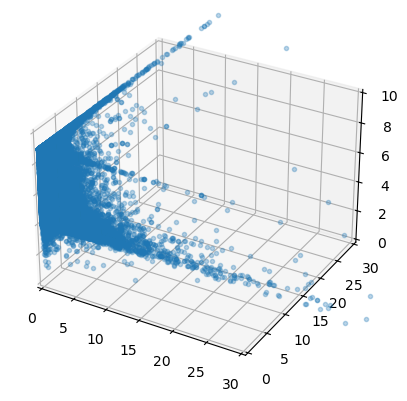

In [53]:
ax = plt.axes(projection='3d')
ax.plot3D(train['threeBRfillfac'], train['MMRstrengthnear'],np.log10(train['instability_time']),'.', alpha = 0.3)
ax.set_xlim([0,30])
ax.set_zlim([0,10])
ax.set_ylim([0,30])

In [120]:
test['spockres'] = testModel.predict(test[MMRDATA])

/tmp/ipykernel_23824/1980874473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['spockres'] = testModel.predict(test[MMRDATA])


In [36]:
regtest = test.drop(test[test['instability_time'] >=1e9].index)


In [121]:
test

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EMouter,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,spockres
110834,28623,28623,0.371990,0.019563,0.006857,True,0.002472,True,0.003948,0.516123,...,0.059041,0.035316,True,False,2.689905e+06,1.388138e+07,0,0.656073,0.003111,1
110835,69249,69249,0.070013,0.121733,0.075546,False,0.002631,False,0.007652,0.169723,...,0.012004,0.011525,True,False,2.285046e+06,9.885070e+05,0,0.163785,0.002628,0
110836,126953,126953,0.134456,0.104013,0.009641,False,0.000125,True,0.001074,0.399606,...,0.060579,0.063726,True,False,1.199777e+05,2.158910e+05,0,0.373951,0.003074,0
110837,122796,122796,0.151126,0.088109,0.084463,False,0.001135,False,0.013893,0.391030,...,0.062948,0.014957,True,False,1.782515e+05,1.000000e+09,0,0.381136,0.002783,0
110838,113465,113465,0.069015,1.181315,0.013833,False,0.001337,True,0.001909,0.077526,...,0.018324,0.008897,True,False,8.174826e+05,1.343023e+05,0,0.099477,0.001439,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.069285,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790,0
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.148656,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434,0
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.220995,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801,0
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.015892,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754,0


In [123]:
test['spockright'] = test['Stable']==test['spockres']

/tmp/ipykernel_23824/1426527784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['spockright'] = test['Stable']==test['spockres']


In [124]:
test

,level_0,index,EMcrossnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,EMcrossfar,...,EPouter,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,EMavg,Widavg,spockres,spockright
110834,28623,28623,0.371990,0.019563,0.006857,True,0.002472,True,0.003948,0.516123,...,0.035316,True,False,2.689905e+06,1.388138e+07,0,0.656073,0.003111,1,False
110835,69249,69249,0.070013,0.121733,0.075546,False,0.002631,False,0.007652,0.169723,...,0.011525,True,False,2.285046e+06,9.885070e+05,0,0.163785,0.002628,0,True
110836,126953,126953,0.134456,0.104013,0.009641,False,0.000125,True,0.001074,0.399606,...,0.063726,True,False,1.199777e+05,2.158910e+05,0,0.373951,0.003074,0,True
110837,122796,122796,0.151126,0.088109,0.084463,False,0.001135,False,0.013893,0.391030,...,0.014957,True,False,1.782515e+05,1.000000e+09,0,0.381136,0.002783,0,True
110838,113465,113465,0.069015,1.181315,0.013833,False,0.001337,True,0.001909,0.077526,...,0.008897,True,False,8.174826e+05,1.343023e+05,0,0.099477,0.001439,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,73201,73201,0.093779,1.010805,0.053300,False,0.019280,True,0.019682,0.311751,...,0.008306,True,False,4.433063e+04,4.833132e+04,0,0.280098,0.012790,0,True
138539,96619,96619,0.211884,0.633114,0.000953,False,0.004110,True,0.000853,0.212120,...,0.133666,True,False,1.177032e+05,9.628703e+04,0,0.297651,0.005434,0,True
138540,111485,111485,0.118282,0.335324,0.056656,False,0.007004,True,0.013420,0.209238,...,0.130572,True,False,1.794668e+05,9.150920e+04,0,0.226596,0.012801,0,True
138541,110503,110503,0.099747,0.086785,0.024360,False,0.001571,True,0.004681,0.183172,...,0.019474,True,False,9.634037e+04,7.603762e+04,0,0.194704,0.002754,0,True


In [127]:
tR = test.drop(test[test['spockright'] ==False].index)

In [128]:
tW = test.drop(test[test['spockright'] ==True].index)

In [144]:
plot = tR.drop(tR[tR['EMavg']>.5 ].index)

/tmp/ipykernel_23824/905772591.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['EMavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.7)


(4.0, 9.0)

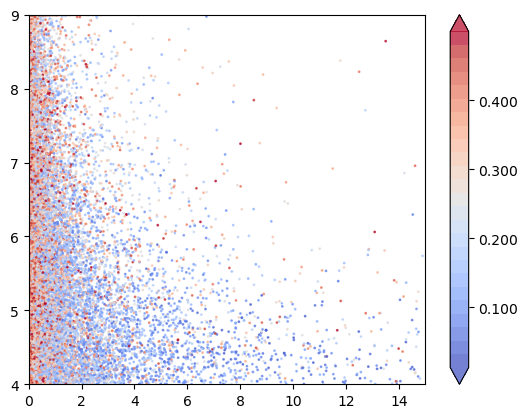

In [149]:
ax = plt.axes()
plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['EMavg'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.7)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,15])
ax.set_ylim([4,9])